<a href="https://colab.research.google.com/github/aditidagar/ocular_disease_recog/blob/vgg19/MODEL/vgg19-retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
mkdir ~/.kaggle

In [2]:
cp kaggle.json ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/ODIR-5K'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
df = pd.read_csv("/content/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [7]:
def has_retinopathy(text):
    if "moderate non proliferative retinopathy" in text:
        return 1
    else:
        return 0

In [8]:
df["left_retinopathy"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
df["right_retinopathy"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))

In [9]:
left_retinopathy = df.loc[(df.D ==1) & (df.left_retinopathy == 1)]["Left-Fundus"].values
left_retinopathy[:15]

array(['2_left.jpg', '5_left.jpg', '11_left.jpg', '26_left.jpg',
       '44_left.jpg', '46_left.jpg', '47_left.jpg', '50_left.jpg',
       '72_left.jpg', '74_left.jpg', '77_left.jpg', '81_left.jpg',
       '87_left.jpg', '90_left.jpg', '93_left.jpg'], dtype=object)

In [10]:
right_retinopathy = df.loc[(df.D ==1) & (df.right_retinopathy == 1)]["Right-Fundus"].values
right_retinopathy[:15]

array(['2_right.jpg', '5_right.jpg', '6_right.jpg', '11_right.jpg',
       '26_right.jpg', '27_right.jpg', '44_right.jpg', '50_right.jpg',
       '54_right.jpg', '81_right.jpg', '89_right.jpg', '90_right.jpg',
       '93_right.jpg', '96_right.jpg', '107_right.jpg'], dtype=object)

In [11]:
print("Number of images in left retinopathy: {}".format(len(left_retinopathy)))
print("Number of images in right retinopathy: {}".format(len(right_retinopathy)))

Number of images in left retinopathy: 917
Number of images in right retinopathy: 960


In [12]:
left_normal = df.loc[(df.D ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.D ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['3140_right.jpg', '2983_right.jpg', '879_right.jpg',
       '3076_right.jpg', '3216_right.jpg', '3433_right.jpg',
       '2805_right.jpg', '2943_right.jpg', '2996_right.jpg',
       '2813_right.jpg', '2681_right.jpg', '2538_right.jpg',
       '2793_right.jpg', '2899_right.jpg', '2558_right.jpg'], dtype=object)

In [13]:
retinopathy = np.concatenate((left_retinopathy,right_retinopathy),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [14]:
print(len(retinopathy),len(normal))

1877 500


In [15]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [16]:
dataset = create_dataset(retinopathy,1)

100%|██████████| 1877/1877 [00:09<00:00, 202.83it/s]


In [17]:
len(dataset)

1847

In [18]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 198.69it/s]


In [19]:
len(dataset)

2347

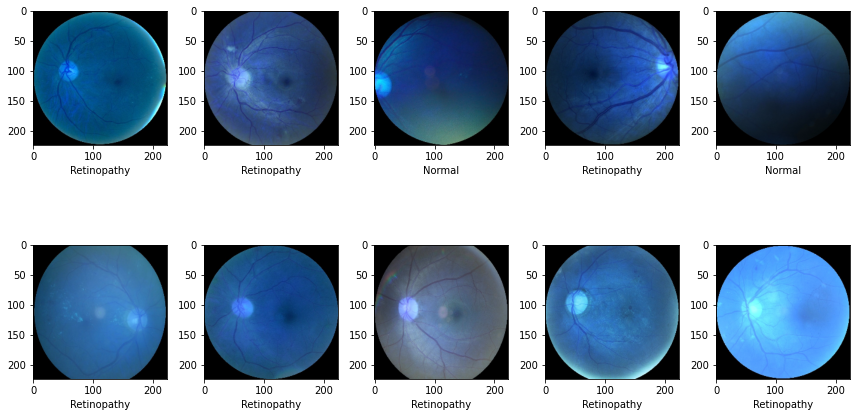

In [20]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Retinopathy"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [21]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [23]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80150528/80134624 [==============================] - 1s 0us/step


In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [29]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
59/59 [==============================] - 53s 579ms/step - loss: 2.6356 - accuracy: 0.7144 - val_loss: 1.7228 - val_accuracy: 0.7830
Epoch 2/15
59/59 [==============================] - 20s 341ms/step - loss: 0.8870 - accuracy: 0.8402 - val_loss: 1.2811 - val_accuracy: 0.8043
Epoch 3/15
59/59 [==============================] - 20s 342ms/step - loss: 0.3098 - accuracy: 0.9169 - val_loss: 1.6721 - val_accuracy: 0.6681
Epoch 4/15
59/59 [==============================] - 20s 343ms/step - loss: 0.1924 - accuracy: 0.9446 - val_loss: 1.1036 - val_accuracy: 0.7979
Epoch 5/15
59/59 [==============================] - 20s 344ms/step - loss: 0.0831 - accuracy: 0.9702 - val_loss: 1.6178 - val_accuracy: 0.8489
Epoch 6/15
59/59 [==============================] - 20s 344ms/step - loss: 0.0736 - accuracy: 0.9750 - val_loss: 1.1713 - val_accuracy: 0.8468
Epoch 7/15
59/59 [==============================] - 20s 343ms/step - loss: 0.0205 - accuracy: 0.9915 - val_loss: 1.2449 - val_accuracy: 0.8489

In [31]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

15/15 [==============================] - 4s 274ms/step - loss: 1.2007 - accuracy: 0.8574
loss: 1.2007440328598022
Accuracy: 0.8574467897415161


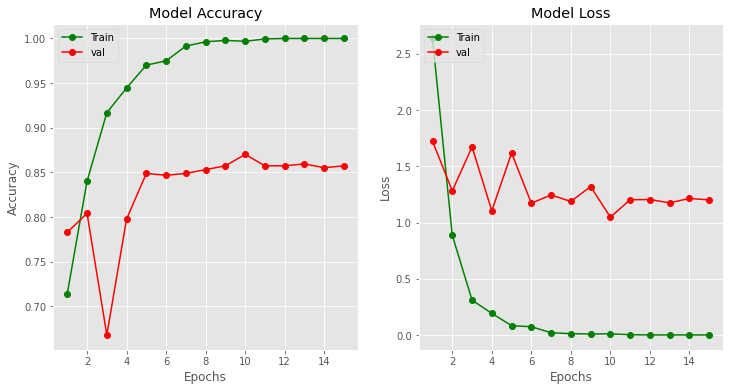

In [32]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()